### started making example plot that would be similar to stringer 2019 fig 2D

predicted time series does not look very good 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.readout import predict_downstream_reduced_rank_regressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
basepath = "Z:\Data\HMC1\day12"

reference_region=["CA1"]
target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"]
rip_exp_start=0.05
rip_exp_stop=0.2

(
    st,
    cm,
    ripple_epochs,
    ep_epochs,
    ep_df,
    session_epoch,
    nrem_epochs,
    wake_epochs,
) = predict_downstream_reduced_rank_regressor.get_data(
    basepath,
    target_regions,
    reference_region,
    rip_exp_start=rip_exp_start,
    rip_exp_stop=rip_exp_stop,
)

In [4]:
curr_ripples = ripple_epochs[wake_epochs]

st_par = functions.get_participation(
    st[wake_epochs].data,
    curr_ripples.starts,
    curr_ripples.stops,
    par_type="firing_rate",
)

In [5]:
ca1_idx = (
    cm.brainRegion.str.contains("CA1").values
    & (cm.deepSuperficial == "Deep")
    & (cm.putativeCellType.str.contains("Pyr"))
)
target_idx = (
    cm.brainRegion.str.contains("PFC").values
    & cm.putativeCellType.str.contains("Pyr").values
)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(st_par)

X_train, X_test, y_train, y_test = train_test_split(
    X[ca1_idx, :].T,
    X[target_idx, :].T,
    test_size=0.4,
    random_state=42,
    shuffle=False,
)
n_grid=20  # number of grid search parameters to use
max_rank=30
cv=5
grid_search_result = predict_downstream_reduced_rank_regressor.run_grid_search(
    X_train, y_train, n_grid=n_grid, cv=cv, max_rank=max_rank
)


In [61]:
from ripple_heterogeneity.utils import (
    kernel_reduced_rank_ridge_regression,
)
from sklearn.metrics import mean_squared_error

regressor = (
    kernel_reduced_rank_ridge_regression.ReducedRankRegressor()
)
regressor.rank = int(grid_search_result.best_params_["rank"])

regressor.reg = 1

regressor.fit(X_train, y_train)

mse = mean_squared_error(
    y_test, regressor.predict(X_test), multioutput="raw_values"
)


In [24]:
np.argsort(mse)

# np.sort(mse)

array([ 8, 45, 44, 81, 10, 11, 73,  5,  6, 49, 50, 48, 70, 42, 63,  2, 52,
       75, 57, 29, 31, 54, 27, 32,  1, 18, 61, 40, 72, 77, 20, 60, 68, 39,
       22, 74, 59, 43, 25, 19, 85, 86, 23, 24, 80, 78, 83, 33, 34, 82, 84,
        3, 69, 56, 12, 30, 66,  9, 67,  4, 71, 47, 58, 35, 65, 21, 37, 26,
       79, 64, 51, 41, 76, 62, 46, 13,  7, 28, 53, 16, 15, 14, 36, 17,  0,
       38, 55], dtype=int64)

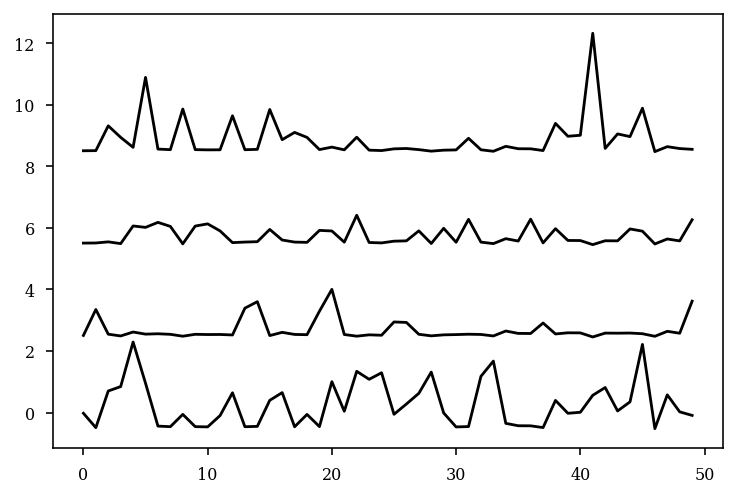

In [62]:
for i in range(4):
    plt.plot(X_test[0:50,i]+i*3,color='k')

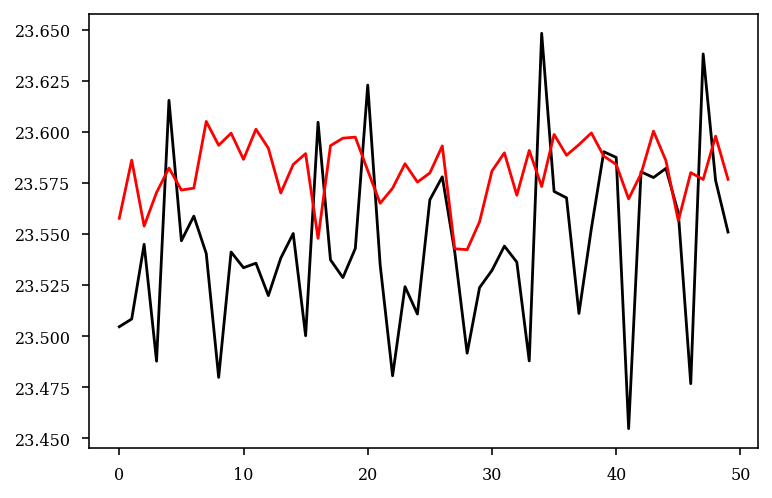

In [63]:
# y_test[0:50,8]
i=8
plt.plot(y_test[0:50,i]+i*3,color='k')

plt.plot(y_pred[0:50,i]+i*3,color='r')


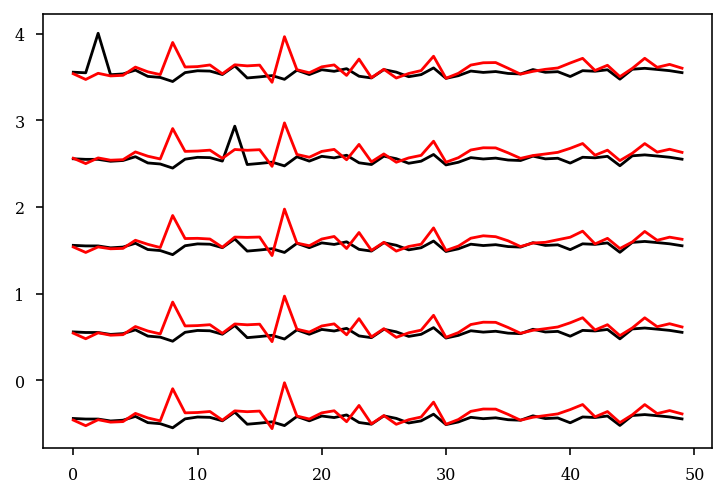

In [66]:
y_pred = regressor.predict(X_test)

for i,unit in enumerate(np.argsort(mse)[:5]):
    plt.plot(y_test[100:150,unit]+i,color='k')

    plt.plot(y_pred[100:150,unit]+i,color='r')

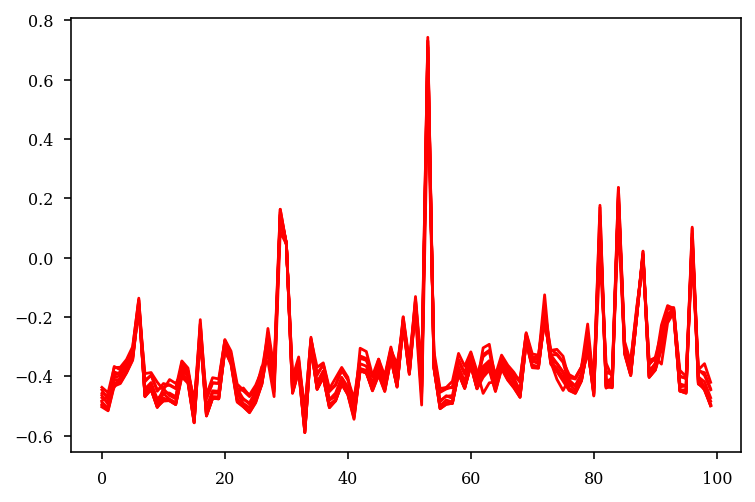

In [67]:
# sns.heatmap(y_pred.T)

for i,unit in enumerate(np.argsort(mse)[:10]):

    plt.plot(y_pred[0:100,unit],color='r')

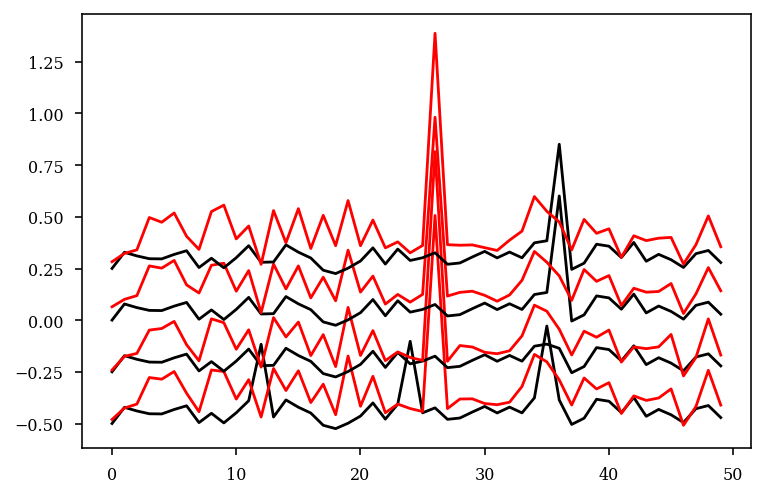

In [93]:
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression

# mdl = CCA().fit(X_train, y_train)
regressor.reg = 0.0001
regressor.rank = 10

regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_test)

mse = mean_squared_error(
    y_test, regressor.predict(X_test), multioutput="raw_values"
)
for i,unit in enumerate(np.argsort(mse)[:4]):
    plt.plot(y_test[450:500,unit]+i*.25,color='k')

    plt.plot(y_pred[450:500,unit]+i*.25,color='r')

In [75]:
np.argsort(mse)

array([ 8, 44, 45, 81, 10, 11, 73, 49,  6, 50, 48,  5, 70, 42,  2, 29, 75,
       52, 57, 63, 54, 27, 31, 61, 18,  1, 32, 40, 20, 77, 72, 60, 68, 59,
       19, 22, 39, 25, 74, 43, 85, 86, 24, 23, 82, 83, 84, 78, 33, 34,  3,
       69, 12, 30, 67, 66, 80, 58,  9, 35,  4, 21, 56, 65, 47, 26, 37, 79,
       64, 71, 62, 41, 46, 76, 13,  7, 51, 28, 16, 14, 15, 36, 17,  0, 38,
       53, 55], dtype=int64)

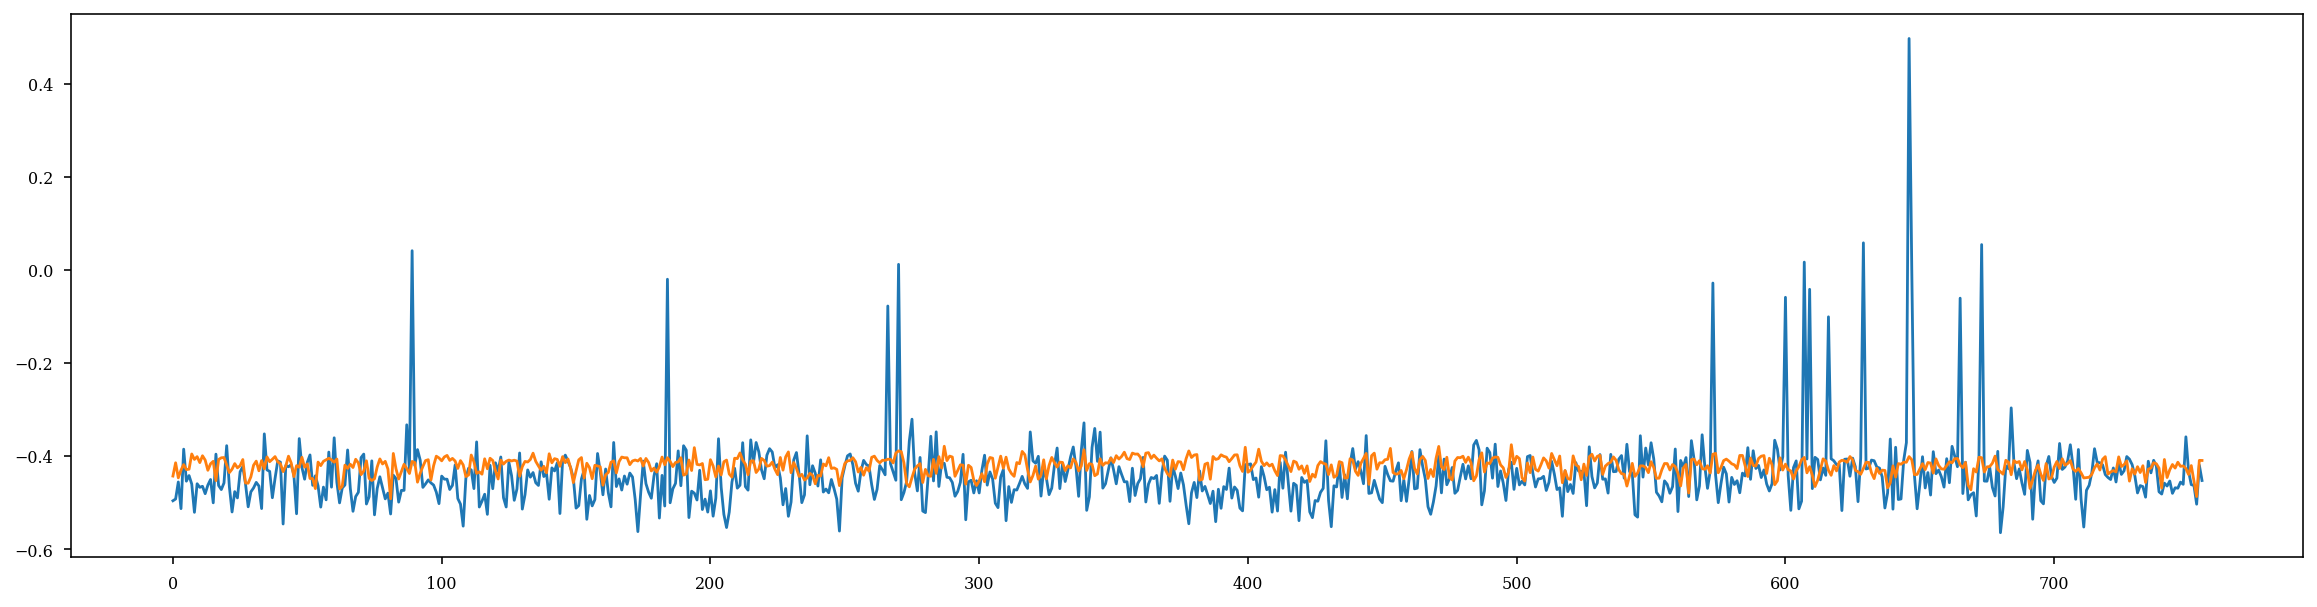

In [84]:
plt.figure(figsize=(20,5))
plt.plot(y_test[:,8])
plt.plot(y_pred[:,8])


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
# temp_df = pd.DataFrame()
fig = go.Figure()

fig.add_trace(px.line(y_test[:,8]))

# fig = px.line(y_test[:,8])
# fig = px.line(y_pred[:,8])
fig.show()

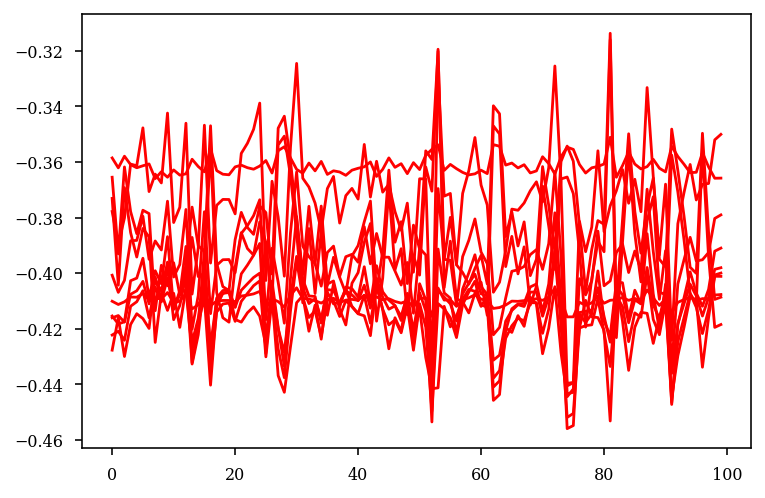

In [49]:
for i,unit in enumerate(np.argsort(mse)[:10]):

    plt.plot(y_pred[0:100,unit],color='r')

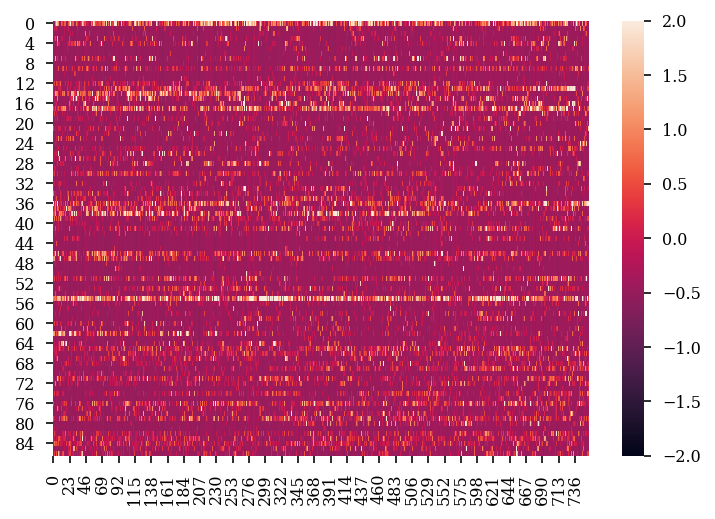

<AxesSubplot:>

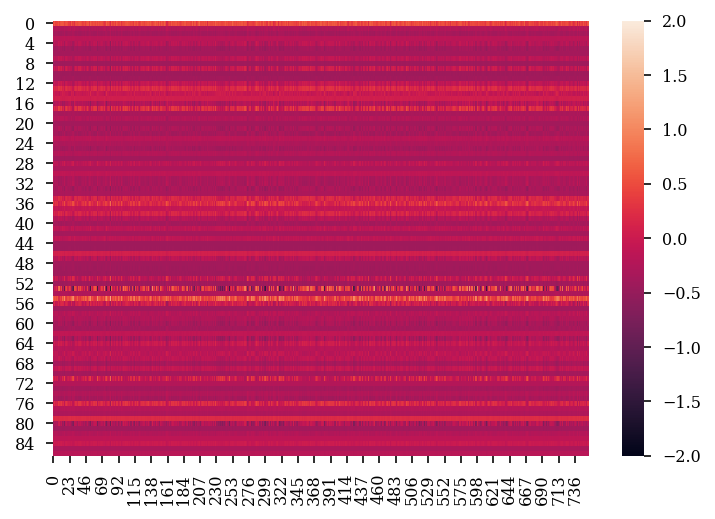

In [55]:
sns.heatmap(y_test.T,vmin=-2,vmax=2)
plt.show()
sns.heatmap(y_pred.T,vmin=-2,vmax=2)
